In [43]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from utils import load_all_images

PIXELS = 50

In [31]:
# settings
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (7, 5)

In [8]:
X, y = load_all_images(classes=['sunny', 'cloudy'], pixels=PIXELS)
len(X)

12976

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, shuffle=True, random_state=777
)

# Binary Classification

## LogisticRegression

### Basic

In [20]:
# create Logisitc Model
log_model = LogisticRegression(
    max_iter=3000,
    verbose=True,
)

result = log_model.fit(X_train, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2501     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29586D+03    |proj g|=  4.91114D+02

At iterate   50    f=  5.01651D+03    |proj g|=  3.22159D+01

At iterate  100    f=  4.81408D+03    |proj g|=  2.97305D+01

At iterate  150    f=  4.68747D+03    |proj g|=  2.19654D+01

At iterate  200    f=  4.61583D+03    |proj g|=  1.38268D+01

At iterate  250    f=  4.57118D+03    |proj g|=  1.44663D+01

At iterate  300    f=  4.54165D+03    |proj g|=  1.34950D+01

At iterate  350    f=  4.52254D+03    |proj g|=  1.45914D+01

At iterate  400    f=  4.51412D+03    |proj g|=  2.84638D+00

At iterate  450    f=  4.50791D+03    |proj g|=  3.33854D+00

At iterate  500    f=  4.50468D+03    |proj g|=  1.09227D+01

At iterate  550    f=  4.50287D+03    |proj g|=  2.49857D+00

At iterate  600    f=  4.50197D+03    |proj g|=  1.35207D+00

At iterate  650    f=  4.5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s finished


Model accuracy: 0.633
Model accuracy: 0.787


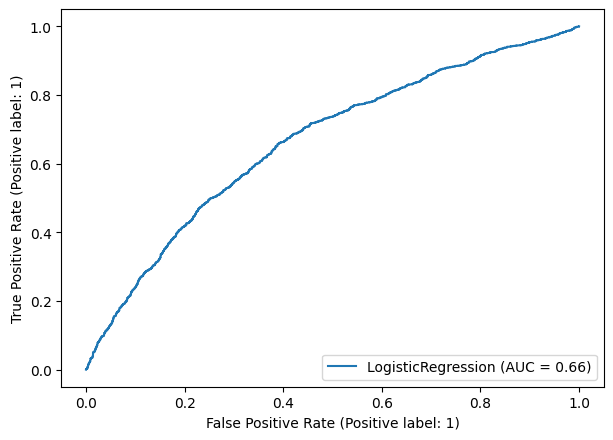

In [33]:
#| echo: false
print(f'Model accuracy: {result.score(X_test, y_test):.3}')
print(f'Model accuracy: {result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(result, X_test, y_test)
plt.show()

### Tuning

In [ ]:
# create Logisitc Model
log_cv = LogisticRegressionCV(
    cv=5,
    solver="saga",
    scoring="accuracy",
    n_jobs=-1,
    verbose=True,
    max_iter=2000,
)

# train
results = log_cv.fit(X_train, y_train)

Model accuracy: 0.678


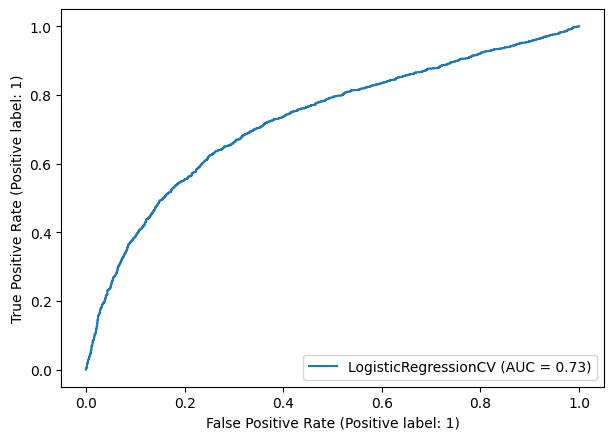

In [42]:
#| echo: false
print(f'Model accuracy: {results.score(X_test, y_test):.3}')

RocCurveDisplay.from_estimator(results, X_test, y_test)
plt.show()

## KNN
### Basic

In [106]:
# create KNN model
knn = KNeighborsClassifier()

knn_result = knn.fit(X_train, y_train)

Model accuracy: 0.686
Model accuracy: 0.776


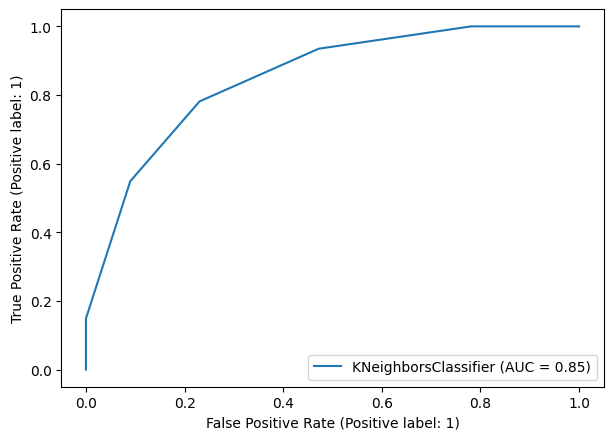

In [107]:
#| echo: false
print(f'Model accuracy: {knn_result.score(X_test, y_test):.3}')
print(f'Model accuracy: {knn_result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(knn_result, X_train, y_train)
plt.show()

### Tuning

In [108]:
# create repeated 10-Fold
kfold = RepeatedKFold(n_splits=5, n_repeats=10)

param_grid = {"n_neighbors": range(1, 50, 4)}

knn_search = GridSearchCV(
    knn, param_grid, cv=kfold, scoring="roc_auc", n_jobs=-1
)
result = knn_search.fit(X_train, y_train)

Model accuracy: 0.778
Model accuracy: 0.837


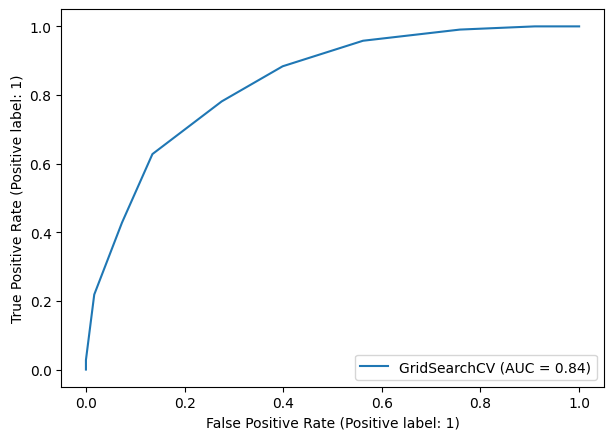

In [109]:
#| echo: false
print(f'Model accuracy: {result.score(X_test, y_test):.3}')
print(f'Model accuracy: {result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(result, X_train, y_train)
plt.show()

## Decision Trees

### Basic with Tuning

In [90]:
# create DecisionTree model
dt_model = DecisionTreeClassifier()

# create 5-Fold CV
kfold = KFold(5, shuffle=True)


# GridSearch
dt_search = GridSearchCV(
    dt_model,
    param_grid={
        "max_depth": range(1, 10),
        "min_samples_split": range(2, 10),
        "ccp_alpha": [0.1, 0.001, 0.0001, 0.00001],
    },
    cv=kfold,
    n_jobs=-1,
    verbose=3,
    scoring="accuracy",
)

dt_result = dt_search.fit(X_train, y_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=2;, score=0.517 total time=   1.1s
[CV 2/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=2;, score=0.522 total time=   1.1s
[CV 3/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=2;, score=0.505 total time=   1.1s
[CV 4/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=2;, score=0.535 total time=   1.1s
[CV 5/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=2;, score=0.508 total time=   1.2s
[CV 1/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=3;, score=0.517 total time=   1.1s
[CV 2/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=3;, score=0.522 total time=   1.1s
[CV 3/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=3;, score=0.505 total time=   1.1s
[CV 4/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=3;, score=0.535 total time=   1.1s
[CV 5/5] END ccp_alpha=0.1, max_depth=1, min_samples_split=3;, score=0.508 total time=   1

In [91]:
dt_result.best_score_, dt_result.best_params_

(0.6975683643707618,
 {'ccp_alpha': 0.001, 'max_depth': 4, 'min_samples_split': 2})

In [92]:
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [98]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

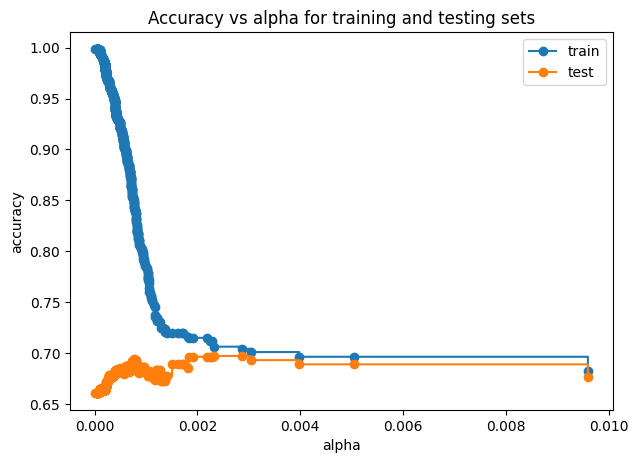

In [100]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas[:-1], train_scores[:-1], marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas[:-1], test_scores[:-1], marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [40]:
#| echo: false
print(f'Model accuracy: {result.score(X_test, y_test):.3}')
print(f'Model accuracy: {result.score(X_train, y_train):.3}')

RocCurveDisplay.from_estimator(result, X_train, y_train)
plt.show()

0.7020925110132159

### With Bagging

## Random Forests

## Gradient Boosting